In [487]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

from scipy.optimize import minimize
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os

NOTE: THE STATE |0> corresponds to z=+1; the state |1> corresponds to z=-1

In [488]:
os.environ['IBM_TOKEN']= "35eb268e2d376c5faea2daf347ef8f602be823198d5e204f79ba6d6a8757746f3a119189dfed4330dfb60c743f73dcaa9908439b410116150f7a40c7a5c6de6c"

In [489]:
load_dotenv()
ibm_token = os.getenv('IBM_TOKEN')

In [490]:
def qubit_idx(i, j, n_cols):
    return i * n_cols + j

In [491]:
def build_ising_pauli_list(J, h):
    """
    Build the Pauli list for a 2D grid Ising Hamiltonian using a numpy array and periodic boundaries.
    
    Args:
        grid (np.ndarray): 2D numpy array of coupling constants (J values) for the grid.
        h (float): External magnetic field strength.
    
    Returns:
        SparsePauliOp: Ising Hamiltonian as a SparsePauliOp.
    """
    rows, cols = J.shape
    n_qubits = rows * cols
    pauli_list = []
    
    n = []

    # Set to track unique pairs
    unique_pairs = set()

    # Iterate over each element in the grid to define nearest-neighbor interactions
    for i in range(rows):
        for j in range(cols):
            # Current qubit index
            current_index = qubit_idx(i, j, cols)

            # Nearest neighbors with periodic boundaries
            neighbors = [
                ((i + 1) % rows, j),  # Down
                ((i - 1) % rows, j),  # Up
                (i, (j + 1) % cols),  # Right
                (i, (j - 1) % cols)   # Left
            ]

            for ni, nj in neighbors:
                neighbor_index = qubit_idx(ni, nj, cols)

                # Ensure unique pairs
                pair = tuple(sorted((current_index, neighbor_index)))
                if pair not in unique_pairs:
            #        n.append((current_index, neighbor_index))
                    unique_pairs.add(pair)

                    # Add interaction term: -J_ij Z_i Z_j
                    paulis = ["I"] * n_qubits
                    paulis[current_index] = "Z"
                    paulis[neighbor_index] = "Z"
                    pauli_list.append(("".join(paulis), -J[i, j]))

            # Add external field term: h Z_i
            paulis = ["I"] * n_qubits
            paulis[current_index] = "Z"
            pauli_list.append(("".join(paulis), h[i, j]))

    
    # Convert to SparsePauliOp
 #   print(n)
    return SparsePauliOp.from_list(pauli_list)

In [492]:
# Define params
n_rows = 2
n_cols = 2
reps = 4

In [524]:
#h = 0.7  # Magnetic field
#h = np.random.rand(n_rows, n_cols)
h = np.load('h_5_5.npy')
n_rows, n_cols = h.shape
J = np.full((n_rows, n_cols), 0.5)
print(h)
ising_hamiltonian = build_ising_pauli_list(J, h)
print(ising_hamiltonian)

[[0.15005067 0.61103358 0.71358537 0.41028108 0.73298685]
 [0.92085189 0.02754327 0.43298144 0.67761797 0.7430438 ]
 [0.98877682 0.88635377 0.82531773 0.58600132 0.63754181]
 [0.08416054 0.57826972 0.5752686  0.22545874 0.32396492]
 [0.0883358  0.93502254 0.51214525 0.30915861 0.025513  ]]
SparsePauliOp(['ZIIIIZIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIZIIII', 'ZZIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIZIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIZIII', 'IZZIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIZIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIZII', 'IIZZIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIZIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIZI', 'IIIZZIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIZIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIZ', 'IIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIZIIIIIIIIIIIIII', 'IIIIIZZIIIIIIIIIIIIIIIIII', 'IIIIIZIIIZIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIII'

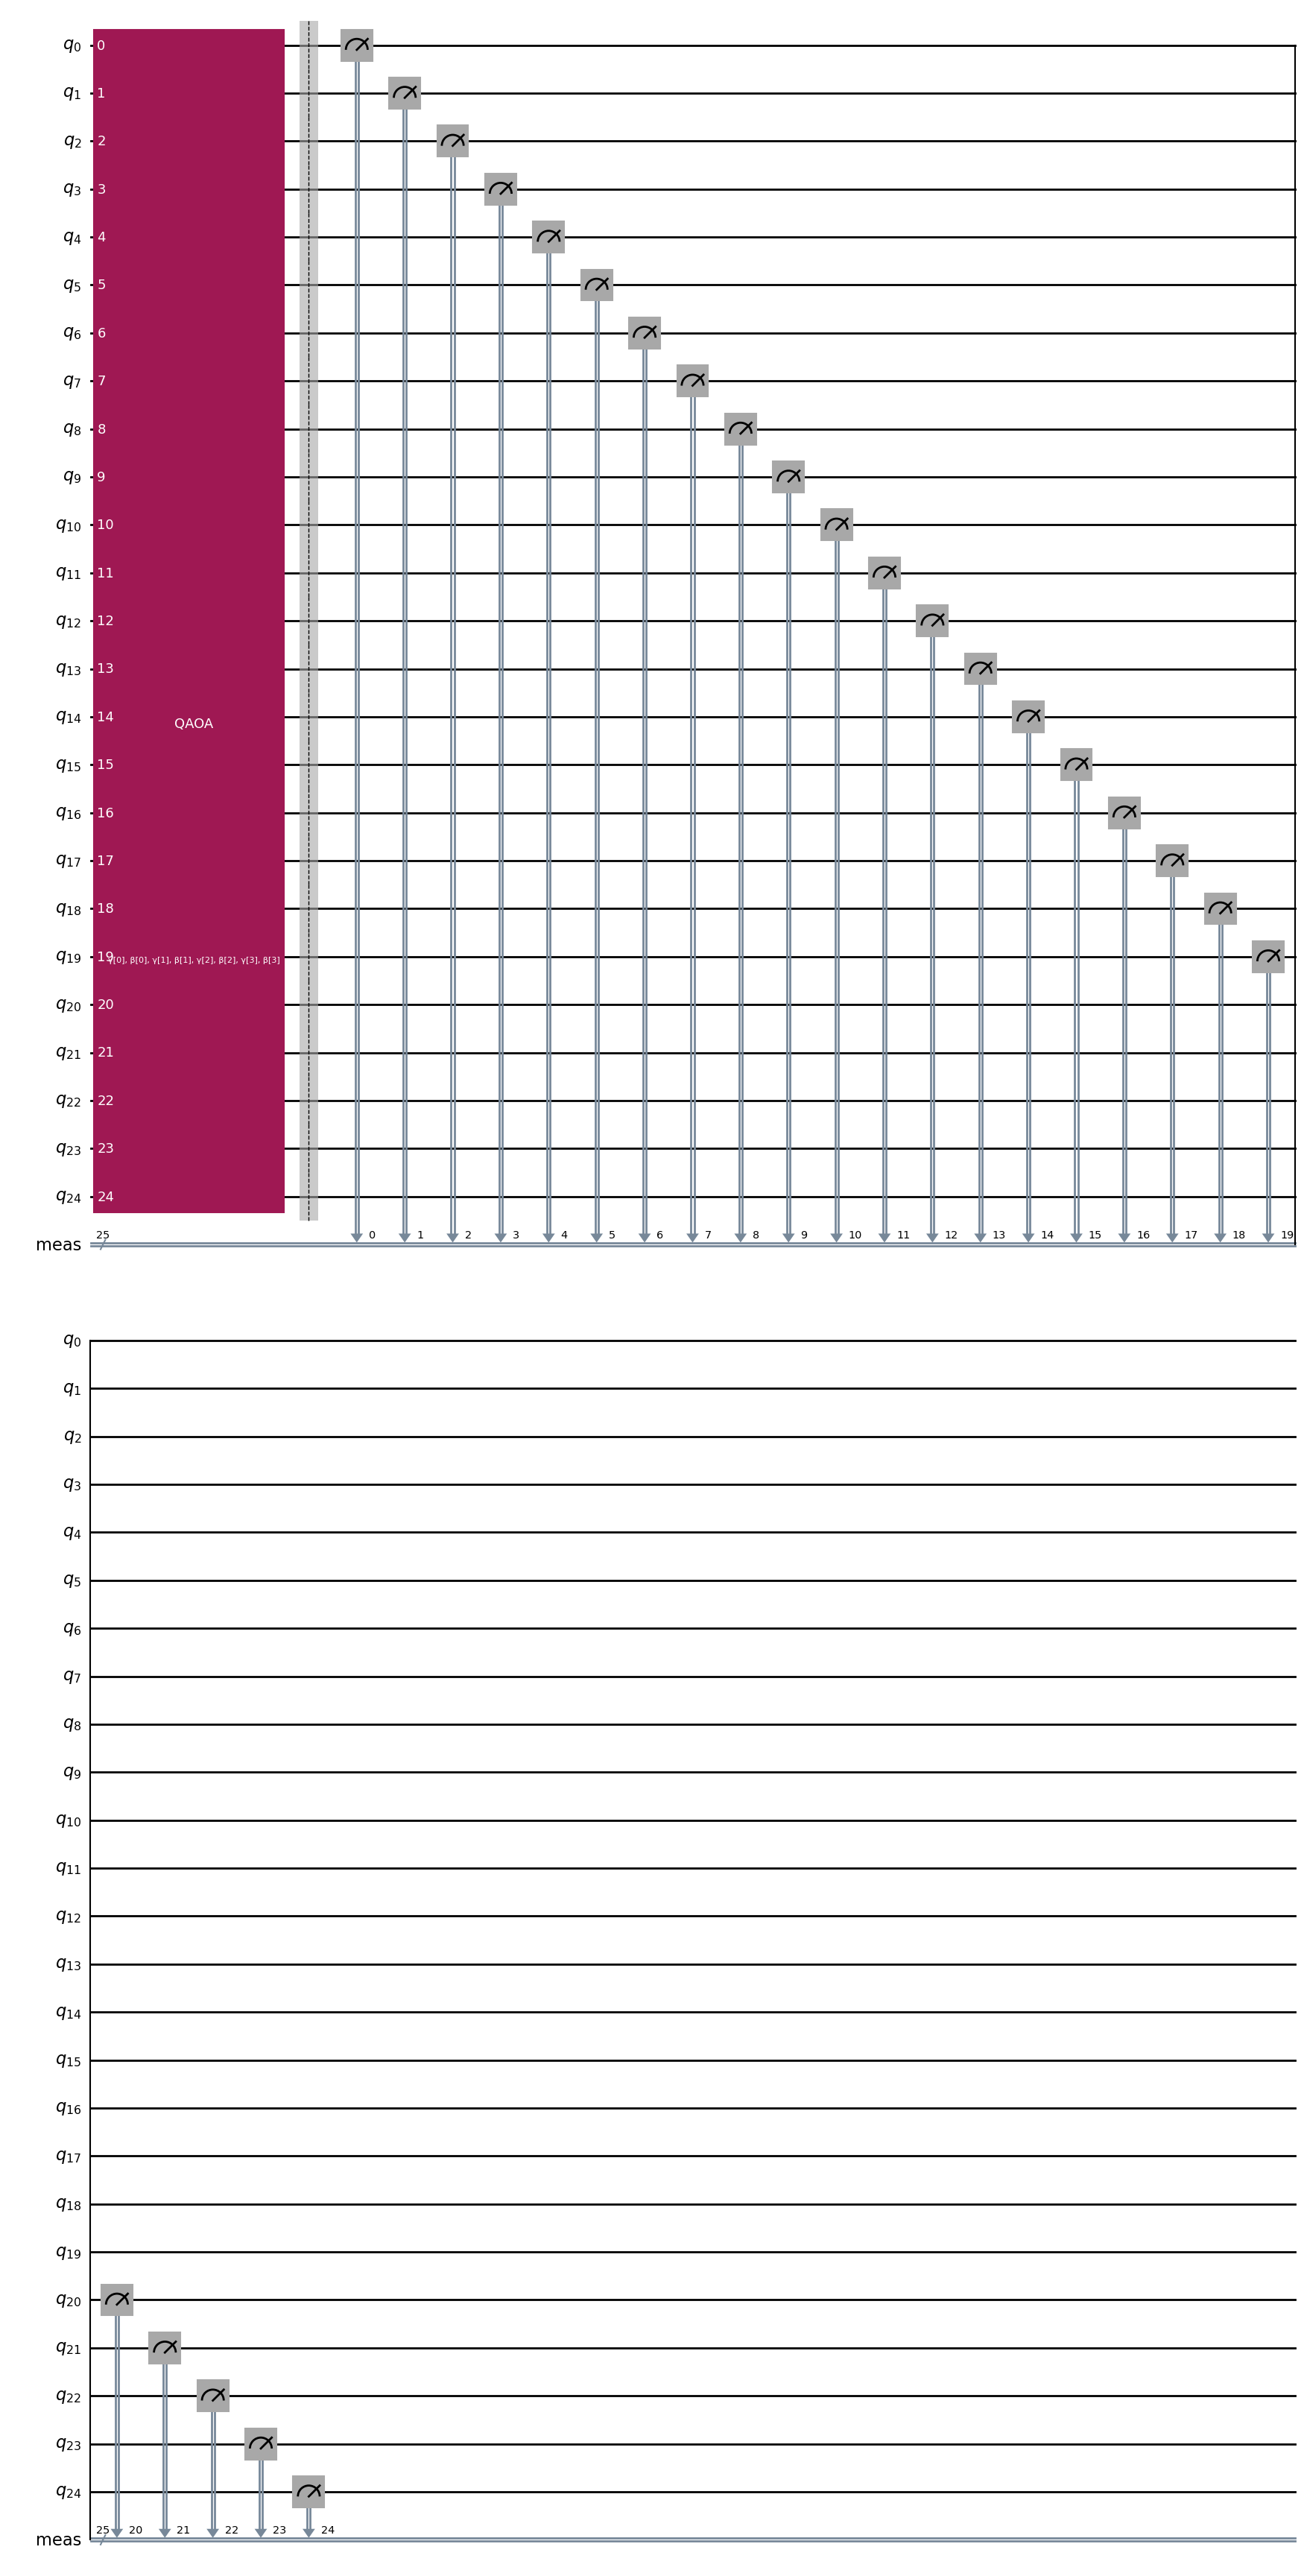

In [525]:
circuit = QAOAAnsatz(cost_operator=ising_hamiltonian, reps=reps)
circuit.measure_all()
circuit.draw('mpl')

In [526]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(β[2]), ParameterVectorElement(β[3]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1]), ParameterVectorElement(γ[2]), ParameterVectorElement(γ[3])])

In [527]:
QiskitRuntimeService.save_account(channel="ibm_quantum", token=ibm_token, overwrite=True, set_as_default=True)

In [528]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
simulator = AerSimulator()

In [529]:
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(min_num_qubits=127)
print(backend)

<IBMBackend('ibm_brisbane')>


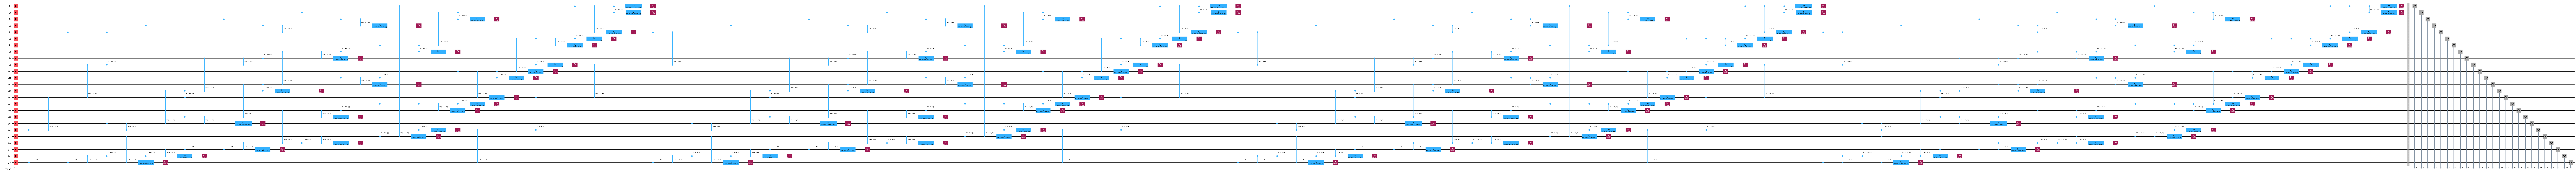

In [530]:
pm = generate_preset_pass_manager(optimization_level=3,backend=simulator)
candidate_circuit = pm.run(circuit)
candidate_circuit.draw('mpl', fold=False, idle_wires=False)


In [531]:
initial_gamma = np.pi
initial_beta = np.pi/2

init_params = []
for i in range(reps):
    init_params.append(initial_gamma)
    init_params.append(initial_beta)


In [532]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [533]:
objective_func_vals = [] # Global variable
with Session(backend=simulator) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, ising_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have n

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -9.920992188020339
       x: [ 3.798e+00  1.580e+00  3.385e+00  1.423e+00  3.129e+00
            1.459e+00  4.183e+00  1.613e+00]
    nfev: 66
   maxcv: 0.0


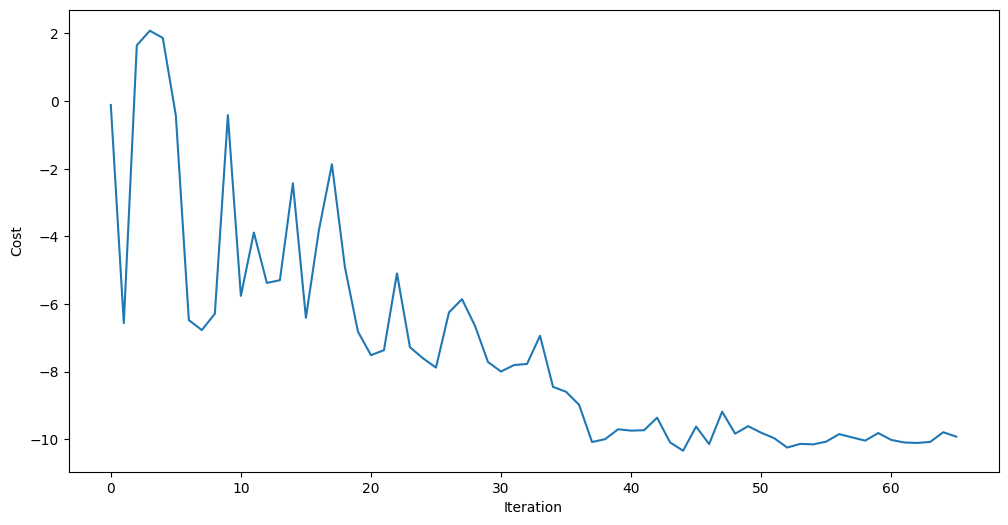

In [534]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

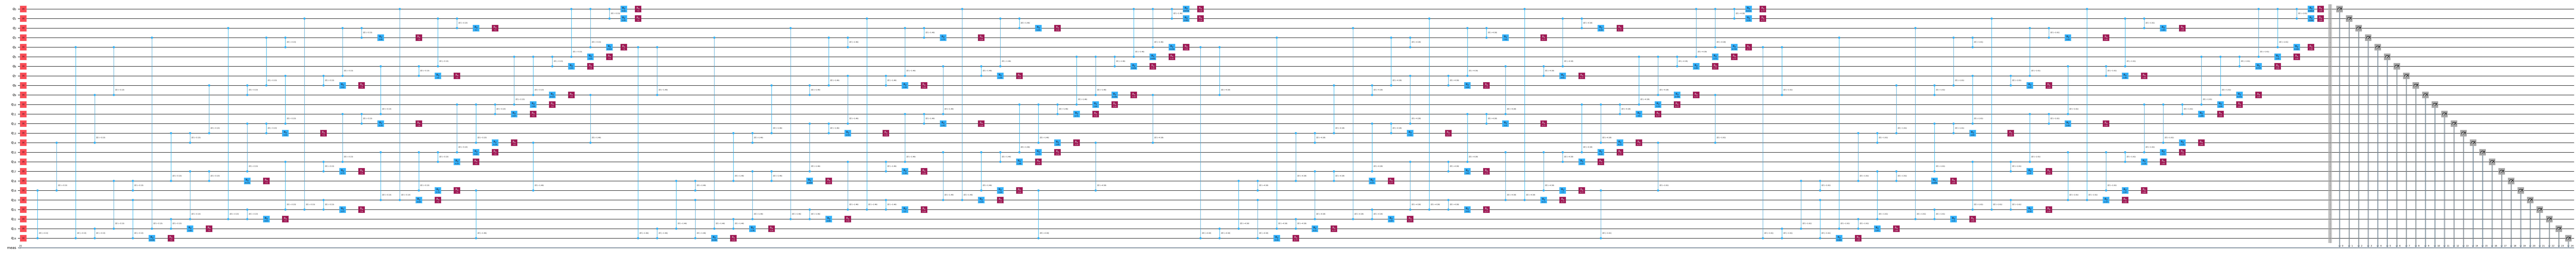

In [535]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

In [536]:
sampler = Sampler(mode=simulator)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

{31456652: 0.002, 7584897: 0.0002, 13868428: 0.0005, 31170557: 0.0001, 30932893: 0.0002, 8101144: 0.0001, 14277896: 0.0001, 13107096: 0.0001, 11927385: 0.0001, 7601548: 0.0007, 7863681: 0.0001, 15990016: 0.0003, 14548224: 0.0004, 16235776: 0.001, 13369240: 0.0001, 15859085: 0.0006, 14195084: 0.0001, 33160324: 0.0002, 6274432: 0.0005, 13876480: 0.0003, 16764447: 0.0001, 30402460: 0.0001, 11642112: 0.0001, 15850500: 0.0003, 14548112: 0.0001, 14007300: 0.0002, 16235785: 0.0002, 5242241: 0.0002, 13942144: 0.0004, 14138764: 0.0041, 13626764: 0.0001, 31309185: 0.0003, 14675740: 0.0001, 16646141: 0.0001, 32230409: 0.0001, 16776217: 0.0002, 16645124: 0.0002, 31307908: 0.0001, 31169932: 0.0001, 16745737: 0.0001, 4701605: 0.0001, 6274308: 0.0001, 6075648: 0.0002, 5504395: 0.0001, 9960456: 0.0001, 6290821: 0.0001, 13286541: 0.0001, 14400925: 0.0002, 16235528: 0.0002, 31260036: 0.0002, 33527972: 0.0001, 16645376: 0.0004, 33553664: 0.0005, 12451213: 0.0001, 13499789: 0.0003, 8237457: 0.0001, 167765

/opt/homebrew/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


In [537]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, (n_rows * n_cols))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]


[0.002  0.0002 0.0005 ... 0.0001 0.0001 0.0001]
[0.0043, 0.0041, 0.0035, 0.0028]


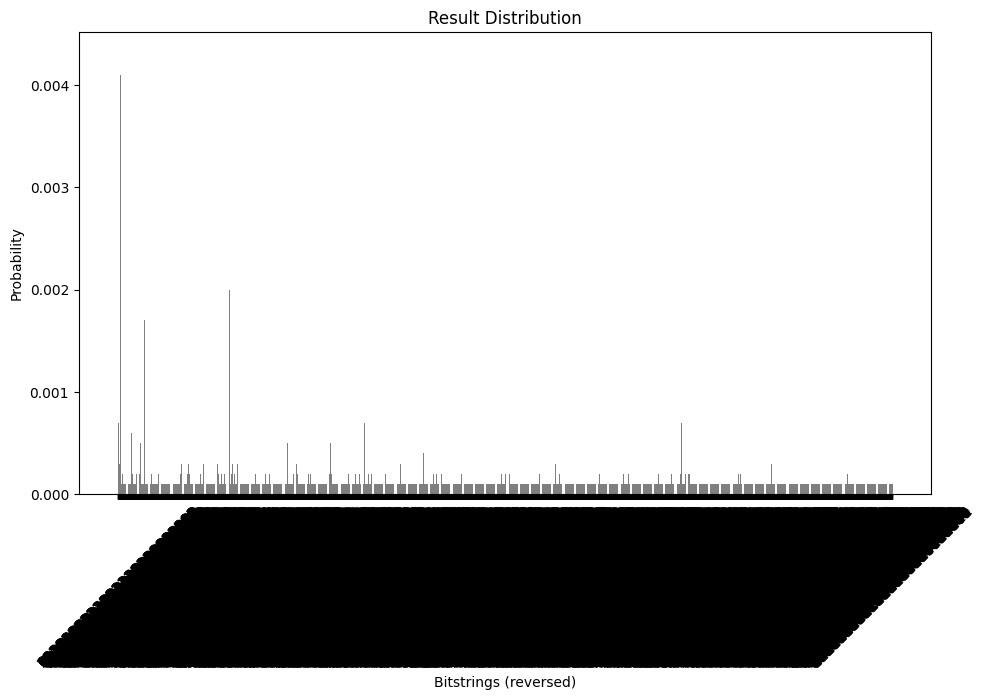

In [538]:
matplotlib.rcParams.update({"font.size": 10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
print(values)
top_4_values = sorted(values, reverse=True)[:4]
print(top_4_values)
positions = []

fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

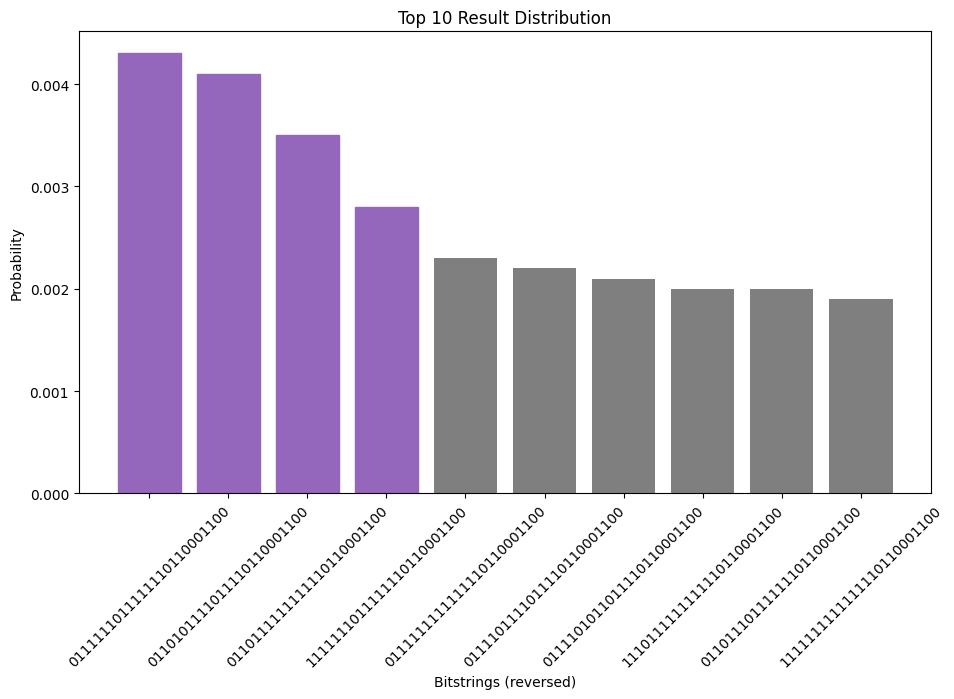

In [539]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_bits is a dictionary of bitstrings and their probabilities
final_bits = final_distribution_bin  # Replace this with your actual data

# Get the top 10 bitstrings by probability
sorted_bits = sorted(final_bits.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_keys = [k for k, _ in sorted_bits]
top_10_values = [v for _, v in sorted_bits]

# Get the indices of the top 4 probabilities
top_4_indices = sorted(range(len(top_10_values)), key=lambda i: top_10_values[i], reverse=True)[:4]

# Create the plot
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)

plt.xticks(rotation=45)
plt.title("Top 10 Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")

# Bar plot for top 10 probabilities
bars = ax.bar(top_10_keys, top_10_values, color="tab:grey")

# Highlight the top 4 bars in purple
for i in top_4_indices:
    bars[i].set_color("tab:purple")

plt.show()
